In [352]:
import numpy as np
import math
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import copy
import sys
import time 

#Numero de vecinos generados
#Tiempo en que va estar un elemento en la lista tabú
#Numero de iteraciones para la diversificación
#La diversificacion funciona como una busqueda en el mejor resultado

ListOfListType = list[list[int or float]]
ObjetiveType = [[ListOfListType, ListOfListType], int or float]

class TabuSearch(object):

    def __init__(self, number_neighbors_generated = 5, time_tabu_list = 3, iterations_diversification = 10, data = [], capacity = 0, iterations = 10):
        self.number_neighbors_generated = number_neighbors_generated
        self.time_tabu_list = time_tabu_list
        self.iterations_diversification = iterations_diversification
        self.data = data
        self.capacity = capacity
        self.iterations = iterations

    def cost_function(self, f, x):
        return f(self.data, x)

    def get_value_by_index(self, list_of_list: ListOfListType, index: int) -> int or float:
        i = 0
        for list_ in list_of_list:
            for value in list_:
                if(i == index):
                    return value
                i += 1

    def put_value_by_index(self, list_of_list: ListOfListType, index: int, new_value: int or float) -> ListOfListType:
        i = 0
        i_list = 0
        for list_ in list_of_list:
            i_value = 0
            for value in list_:
                if(i == index):
                    list_of_list[i_list][i_value] = new_value
                    return list_of_list
                i += 1
                i_value += 1
            i_list += 1

    def is_under_demand(self, actual_solution: list) -> bool:
        demands = []
        for route in actual_solution:
            demands.append(self.getDemand(route))

        is_under_demand_ = True
        for demand in demands:
            if(demand > self.capacity):
                is_under_demand_ = False
                    
        return is_under_demand_


    def getTotalDemand(self) -> int or float:
        totalDemand = 0
        for element in self.data:
            totalDemand += element[2]
        return totalDemand

    def getDemand(self, route: list) -> int or float:
        demand = 0
        for node in route:
            demand += self.data[node][2]
        return demand

    def create_first_solution(self) -> ListOfListType:
        totalDemand = self.getTotalDemand()
        totalCars = math.ceil(totalDemand / self.capacity)

        while(1):
            routes = []
            for i in np.arange(totalCars):
                routes.append([])
            demands = []

            lista = list(range(1,(len(self.data))))
            random.shuffle(lista)

            for i in np.arange(len(self.data) - 1):
                index = random.randint(0,(totalCars - 1))
                routes[index].append(lista[i])

            for route in routes:
                demands.append(self.getDemand(route))
            
            isUnderDemand = True
            for demand in demands:
                if(demand > self.capacity):
                    isUnderDemand = False
            if(isUnderDemand):
                break
        return routes

    def create_dictionary(self, size: int) -> dict:
        dictionary = dict()

        for i in np.arange(size):
            for j in np.arange(size):
                if(i != j):
                    key = str(i) + str(j)
                    dictionary.setdefault(key, 0)
        return dictionary

    def create_simple_neighbor_solution(self, actual_solution: ListOfListType, row: int, column: int) -> ListOfListType:
        neighbor = copy.deepcopy(actual_solution)
        row_value    = self.get_value_by_index(actual_solution, row)
        column_value = self.get_value_by_index(actual_solution, column)

        neighbor = self.put_value_by_index(list_of_list=neighbor, index=row, new_value=column_value)
        neighbor = self.put_value_by_index(list_of_list=neighbor, index=column, new_value=row_value)

        if(self.is_under_demand(actual_solution=neighbor)):
            return neighbor
        return None
    
    ReturnCreateNeighborSolutionType = ListOfListType, list
    def create_neighbor_solutions(self, actual_solution: ListOfListType) -> ReturnCreateNeighborSolutionType:
      total_neighbors_generated = 0
      neighbors = []
      indexes = []

      while(total_neighbors_generated < self.number_neighbors_generated):
          index1 = random.randint(0, len(self.data)-2)
          while(1):
              index2 = random.randint(0, len(self.data)-2)
              if(index2 != index1): break
          neighbor_solution = self.create_simple_neighbor_solution(actual_solution=actual_solution, row=index1, column=index2)
          if(neighbor_solution and not ([index1, index2] in indexes)):
              neighbors.append(neighbor_solution)
              total_neighbors_generated += 1
              indexes.append([index1, index2])
      return neighbors, indexes

    ReturnGetBestNeighborType = list, list
    def get_best_neighbor(self, list_neighbors: ListOfListType, indexes:list, objetive: ObjetiveType, tabu_list: list, actual_cost: int or float) -> ReturnGetBestNeighborType:
        best_cost = float("inf")
        best_neighbor = []
        best_indexs = []
        optional_best_cost = 0
        
        i = 0
        for neighbor in list_neighbors:
            value = self.cost_function(objetive, neighbor)
            if(value < best_cost):
                key = str(indexes[i][0]) + str(indexes[i][1])
                if(tabu_list[key] > 0):
                    best_key = key
                    optional_best_cost = value
                    optional_best_neighbor = neighbor
                    optional_best_indexs = indexes[i]
                else:                    
                    best_cost = value
                    best_neighbor = neighbor
                    best_indexs   = indexes[i]
            i += 1

            if(optional_best_cost):
                if(optional_best_cost < best_cost):
                    if(optional_best_cost < actual_cost):
                        tabu_list[best_key] = self.time_tabu_list
                        return optional_best_cost, optional_best_neighbor, optional_best_indexs
        
        return best_cost, best_neighbor, best_indexs
    

    def modify_dictionary_by_indexs(self, dictionary: dict, indexs: list, value: int) -> None:
        key = str(indexs[0]) + str(indexs[1])
        dictionary[key] = value
    
    def add_frecuency_tabu_list_by_indexs(self, dictionary: dict, indexs: list) -> None:
        key = str(indexs[0]) + str(indexs[1])
        dictionary[key] = dictionary[key] + 1
    
    def update_tabu_list(self, dictionary: dict) -> None:
        for element in dictionary:
            if(dictionary[element] > 0):
                dictionary[element] = dictionary[element] - 1

    def fit(self, objetive: ObjetiveType):
        self.cost_ = []
        self.all_costs = []
        actual_solution = self.create_first_solution()
        actual_cost = self.cost_function(objetive, actual_solution)
        tabu_list = self.create_dictionary((len(self.data) - 1))
        tabu_list_frecuency = self.create_dictionary((len(self.data) - 1))
        iterations_to_diversifications = 0
        last_cost = 0
        best_of_best_cost = float("inf")
        best_of_best_solution = []
        for i in np.arange(self.iterations):
            #Crear soluciones vecinas
            neighbors_solutions, indexes = self.create_neighbor_solutions(actual_solution=actual_solution)
            #print(indexes)
            #Evaluar soluciones vecinas y Elegir mejor solución
            best_cost, best_neighbor, best_indexs = self.get_best_neighbor(list_neighbors=neighbors_solutions, indexes=indexes, objetive=objetive, tabu_list=tabu_list, actual_cost=actual_cost)
            
            self.add_frecuency_tabu_list_by_indexs(dictionary=tabu_list_frecuency, indexs=best_indexs)
            self.all_costs.append((best_cost))

            if(best_cost < actual_cost):
                actual_cost = best_cost
                actual_solution = best_neighbor
                self.modify_dictionary_by_indexs(dictionary=tabu_list, indexs=best_indexs, value=self.time_tabu_list + 1)
            if(best_cost < best_of_best_cost):
                best_of_best_cost = best_cost
                best_of_best_solution = best_neighbor
                self.cost_.append((best_of_best_cost))
            sys.stderr.write('\r%d Iteration | Cost %f' % (i, best_of_best_cost))
            time.sleep(0)
            sys.stderr.flush()
            self.update_tabu_list(dictionary=tabu_list)
            if(last_cost == actual_cost): iterations_to_diversifications += 1
            if(iterations_to_diversifications == self.iterations_diversification):
                actual_solution = self.create_first_solution()
                actual_cost = self.cost_function(objetive, actual_solution)
                tabu_list = self.create_dictionary((len(self.data) - 1))
                iterations_to_diversifications = 0
            last_cost = actual_cost
        self.best_cost = best_of_best_cost
        self.best_solution = best_of_best_solution
        self.tabu_list_frecuency = tabu_list_frecuency

        print(best_of_best_cost, best_of_best_solution)
        print()        

In [353]:
def CVRP_function(routes):
    distance = 0
    for i in np.arange(len(routes)-1):
        distance += np.sqrt((routes[i][0] - routes[i+1][0])**2 + (routes[i][1] - routes[i+1][1])**2)
    return distance

def getAllDistances(data, routes):
    allDistances = 0
    for route in routes:
        coordenates = []
        coordenates.append(data[0][1])
        for node in route:
            coordenates.append(data[node][1])
        coordenates.append(data[0][1])
        allDistances += CVRP_function(coordenates)
    return allDistances

In [354]:
from ReadData import getCVRPFileData
data, capacity = getCVRPFileData('./A-n33-k5.txt')

tb = TabuSearch(number_neighbors_generated=12, time_tabu_list=15, iterations_diversification=80, data=data, capacity=capacity, iterations=50000)
tb.fit(getAllDistances)

49999 Iteration | Cost 708.404920

708.4049197257699 [[22, 28, 11, 6, 24], [23, 18, 19, 14, 21, 1, 31], [2, 20, 32, 13, 8, 7, 4], [10, 25, 30, 27, 5, 26, 12], [29, 16, 3, 9, 17, 15]]



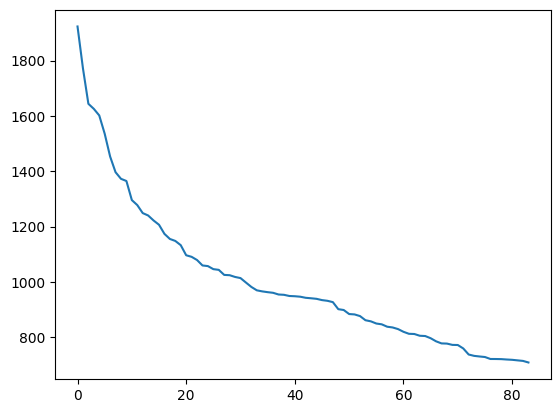

In [355]:
plt.plot(range(len(tb.cost_)), [x for x in tb.cost_ ])
plt.show()

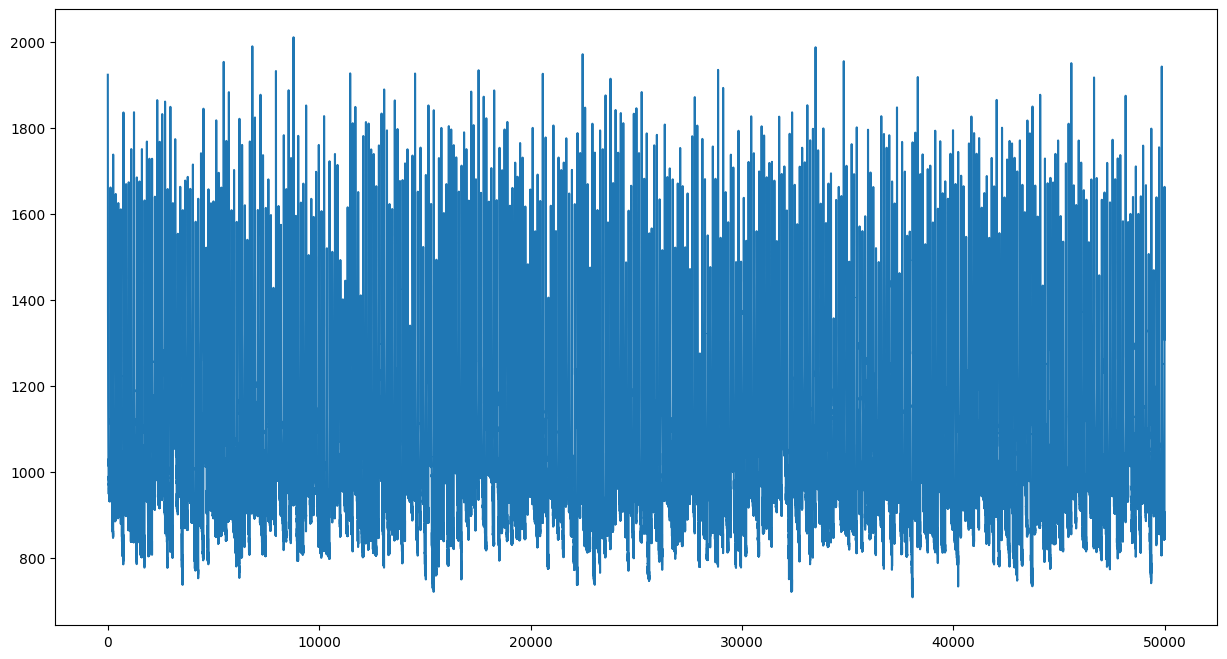

In [356]:
plt.figure(figsize=(15,8))
plt.plot(range(len(tb.all_costs)), [x for x in tb.all_costs ])
plt.show()